# Wczytanie danych:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

#Zbiór danych users
users = pd.read_csv('ausers.csv', delimiter=';')
#print(users.head(50))

In [2]:
anxiety = pd.read_csv('aanxiety.csv', delimiter=';')
print(anxiety.head(5))

duplicates = anxiety.duplicated().sum()
#print(f"Duplikaty: {duplicates}")

            attributes              date email gender
0  3|3|2|3|3|2|0|2|3|0  2021-11-13 14:52  ID13      M
1  2|2|2|1|2|2|0|1|1|1  2021-11-13 14:52  ID48      M
2  3|3|1|2|2|2|2|1|1|1  2021-11-13 15:03   ID6      M
3  2|2|2|2|2|2|1|2|2|2  2021-11-13 15:04   ID5      K
4  1|1|1|1|1|1|0|1|1|2  2021-11-13 15:04  ID34      M


# Usuwanie wierszy:

Do usuwania numery wierszy -2 w stosunku do csv
Powtarzające się ID w aanixiety: 
- ID83 - ponad rok różnicy, zostawione oba
- ID76 - -//-
- ID86 - mniej niż godzina różnicy, wywalić wiersz nr 41 (albo 40 bez nagłówka)
- ID82 - ponad rok różnicy, zostawione oba
- ID215 - ponad dzień różnicy, zostawione oba
- ID162 - mniej niż godzina różnicy, wywalić wiersz nr 70 (albo 69 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz nr 93 (92 bez nagłówka)
- ID214 - 22h różnicy??? - zatwierdzone - oba zostawić!!!
- ID129 - kilka dni różnicy, zostawione oba

W adepression: 
Pierwsze dwa tak samo.
ID86 nie istnieje???
- ID82 - mniej niż godzina różnicy, wywalić wiersz nr 36 (albo 35 bez nagłówka)
- ID212 - parę godzin ponad dzień różnicy, więc zostawione oba???
- ID174 - wywalić wiersz 70

In [3]:
do_usuniecia_anxiety = [39, 68, 91]
anxiety = anxiety.drop(anxiety.index[do_usuniecia_anxiety])
anxiety = anxiety.reset_index(drop=True)

# Przygotowanie danych: 

In [4]:
# Przygotowanie atrybutów anxiety:
anxiety_split = anxiety['attributes'].str.split('|', expand=True)
anxiety_split.columns = [f'f_{i}' for i in range(anxiety_split.shape[1])]
anxiety = pd.concat([anxiety_split, anxiety['date'], anxiety['email'], anxiety['gender']], axis=1)
print(anxiety.head(5))

  f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9              date email gender
0   3   3   2   3   3   2   0   2   3   0  2021-11-13 14:52  ID13      M
1   2   2   2   1   2   2   0   1   1   1  2021-11-13 14:52  ID48      M
2   3   3   1   2   2   2   2   1   1   1  2021-11-13 15:03   ID6      M
3   2   2   2   2   2   2   1   2   2   2  2021-11-13 15:04   ID5      K
4   1   1   1   1   1   1   0   1   1   2  2021-11-13 15:04  ID34      M


# Optymalizacja liczby skupień metodą łokcia

*** Eksperyment numer:1 Jakość= 856.4761904761906
*** Eksperyment numer:2 Jakość= 579.3845766129032
*** Eksperyment numer:3 Jakość= 520.343776106934
*** Eksperyment numer:4 Jakość= 485.16210526315786
*** Eksperyment numer:5 Jakość= 458.2291556262144
*** Eksperyment numer:6 Jakość= 427.71191724941724
*** Eksperyment numer:7 Jakość= 404.0326330532213
*** Eksperyment numer:8 Jakość= 391.3169955044955
*** Eksperyment numer:9 Jakość= 379.88821739663854


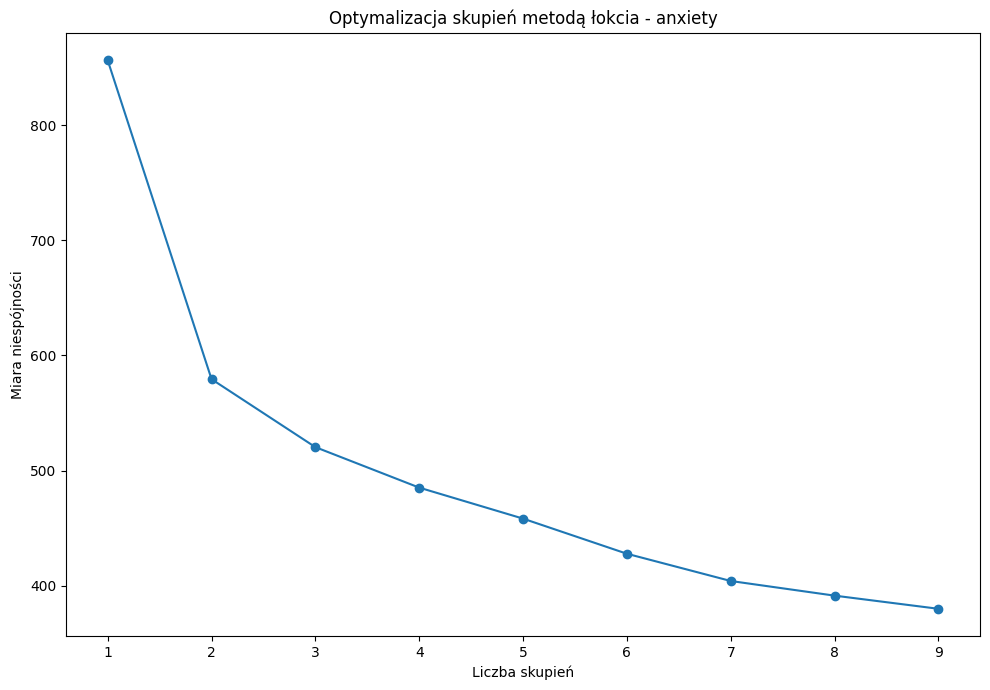

In [5]:
n = 10 #liczba eksperymentów

featuresA = anxiety.iloc[:,0:10] #cechy do grupowania
#print(features)

results = []
for k in range(1, n):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(featuresA)
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = kmeans.inertia_ #Powinna być jak najmniejsza
    
    results.append(inertia)
    
    print("*** Eksperyment numer:"+str(k)+" Jakość=",inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia 
#Widać, że w tym przypadku optymalne k=3

fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,n), results , marker='o')
plt.title("Optymalizacja skupień metodą łokcia - anxiety")
plt.xlabel('Liczba skupień')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()

# Grupowanie metodą K-means

In [6]:
#Grupowanie - anxiety:
#Dla 2 klastrów:
kmeansA = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansA.fit(featuresA) #Grupowanie

inertiaA = kmeansA.inertia_
print("Miara jakości=",inertiaA);

centroidsA = kmeansA.cluster_centers_
print("Centroidy: \n",centroidsA)

clustersA = kmeansA.fit_predict(featuresA)

Miara jakości= 579.3845766129032
Centroidy: 
 [[1.25806452 0.58064516 0.93548387 0.93548387 0.4516129  0.64516129
  0.06451613 0.79032258 0.59677419 0.75806452]
 [2.25       1.59375    1.96875    1.71875    1.453125   1.46875
  0.765625   1.96875    1.53125    1.578125  ]]


In [7]:
#Dla 3 klastrów:
kmeansA3 = KMeans(n_clusters=3, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansA3.fit(featuresA) #Grupowanie

inertiaA3 = kmeansA3.inertia_
print("Miara jakości=",inertiaA3);

centroidsA3 = kmeansA3.cluster_centers_
print("Centroidy: \n",centroidsA3)

clustersA3 = kmeansA3.fit_predict(featuresA)

Miara jakości= 520.343776106934
Centroidy: 
 [[2.48148148 2.         2.11111111 2.         1.96296296 1.81481481
  1.18518519 2.03703704 2.         1.81481481]
 [1.21052632 0.54385965 0.92982456 0.89473684 0.43859649 0.61403509
  0.07017544 0.71929825 0.59649123 0.66666667]
 [2.04761905 1.26190476 1.76190476 1.5        1.02380952 1.19047619
  0.4047619  1.88095238 1.11904762 1.45238095]]


# Ocena jakości grupowania - miara Silhouette

Przyjmuje wartości od -1 do 1, gdzie 1 to idealne dopasowanie, a im bliżej 0, tym gorzej dopasowane są klastry. Wartości poniżej 0 oznaczają złe dopasowanie

In [14]:
from sklearn.metrics import silhouette_score
clustersA = kmeansA.fit_predict(featuresA)
silhouette_avg = silhouette_score(featuresA, clustersA)
print(f"Średnia wartość silhouette dla anxiety, liczba skupień 2: {silhouette_avg:.3f}")

silhouette_avg3 = silhouette_score(featuresA, clustersA3)
print(f"Średnia wartość silhouette dla anxiety, liczba skupień 3: {silhouette_avg3:.3f}")

Średnia wartość silhouette dla anxiety, liczba skupień 2: 0.266
Średnia wartość silhouette dla anxiety, liczba skupień 3: 0.176


*** Eksperyment numer: 2 Jakość dla anxiety =  0.2659666930251444
*** Eksperyment numer: 3 Jakość dla anxiety =  0.1760694087221655
*** Eksperyment numer: 4 Jakość dla anxiety =  0.15428419343985642
*** Eksperyment numer: 5 Jakość dla anxiety =  0.11244215110840575
*** Eksperyment numer: 6 Jakość dla anxiety =  0.12588572030770812
*** Eksperyment numer: 7 Jakość dla anxiety =  0.11972419884348766
*** Eksperyment numer: 8 Jakość dla anxiety =  0.11419099100795055
*** Eksperyment numer: 9 Jakość dla anxiety =  0.11841485500036528


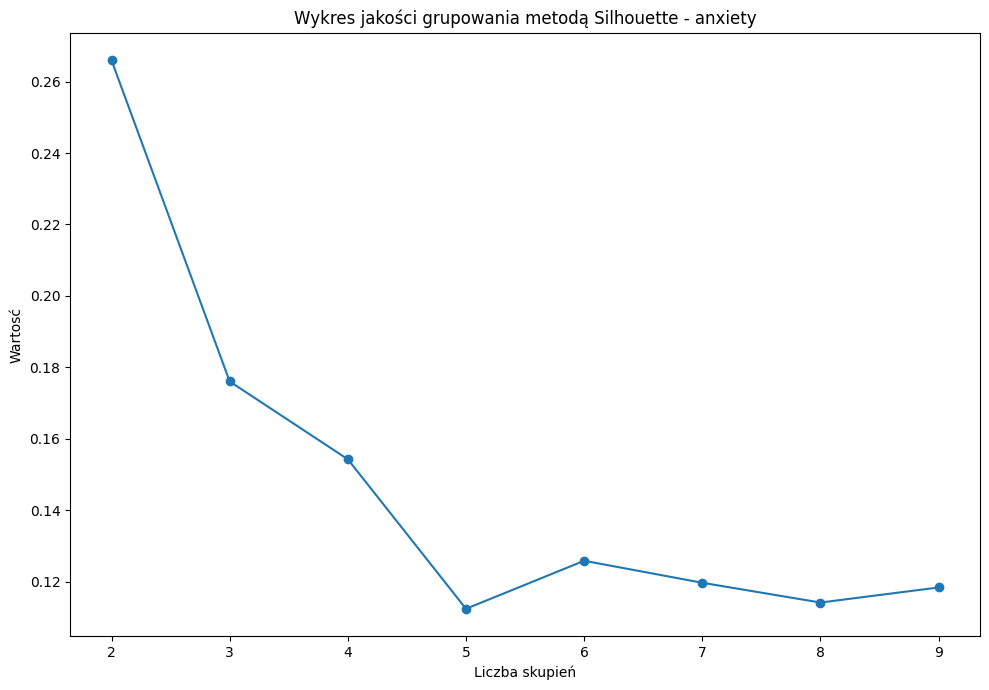

In [9]:
results_anxiety = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    
    kmeans.fit(featuresA) #Grupowanie anxiety
    clustersA = kmeans.predict(featuresA)
    #Obliczenie jakości grupowania
    silhouette_avgA = silhouette_score(featuresA, clustersA) #Powinna być jak najbliższa 1, ale broń Boże nie poniżej 0
    results_anxiety.append(silhouette_avgA)
    
    print("*** Eksperyment numer: " + str(k) + " Jakość dla anxiety = ", silhouette_avgA)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_anxiety , marker='o')
plt.title("Wykres jakości grupowania metodą Silhouette - anxiety")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Indeks Davies - Bouldin

Indeks Davies-Bouldin (DBI) przyjmuje wartości w zakresie od 0 do nieskończoności. W praktyce wyniki zazwyczaj mieszczą się w zakresie od 0 do kilku jednostek, w zależności od charakterystyki danych i jakości klastrów.

Interpretacja wartości DBI:
- 0: Idealne klastry – maksymalna kompaktowość i doskonałe odseparowanie (rzadko osiągane w rzeczywistych danych).
- Niskie wartości (blisko 0): Wskazują na dobrze zdefiniowane klastry – mała rozbieżność w obrębie klastrów oraz duża separacja między nimi.
Wyższe wartości (np. >1): Wskazują na gorszą jakość klastrów – większe nakładanie się klastrów lub brak wyraźnych granic.

In [15]:
# Obliczenie indeksu Davies-Bouldin
from sklearn.metrics import davies_bouldin_score
clustersA = kmeansA.fit_predict(featuresA)

dbi = davies_bouldin_score(featuresA, clustersA)
print(f"Indeks Davies-Bouldin, liczba skupień 2: {dbi:.3f}")

dbi3 = davies_bouldin_score(featuresA, clustersA3)
print(f"Indeks Davies-Bouldin, liczba skupień 3: {dbi3:.3f}")

Indeks Davies-Bouldin, liczba skupień 2: 1.384
Indeks Davies-Bouldin, liczba skupień 3: 1.947


*** Eksperyment numer: 2 Jakość dla anxiety =  1.383810574774287
*** Eksperyment numer: 3 Jakość dla anxiety =  1.9468527769249047
*** Eksperyment numer: 4 Jakość dla anxiety =  1.90352399807299
*** Eksperyment numer: 5 Jakość dla anxiety =  2.063532319594915
*** Eksperyment numer: 6 Jakość dla anxiety =  1.9654036606485092
*** Eksperyment numer: 7 Jakość dla anxiety =  1.848733592784758
*** Eksperyment numer: 8 Jakość dla anxiety =  1.8491540033617528
*** Eksperyment numer: 9 Jakość dla anxiety =  1.8419450731049436


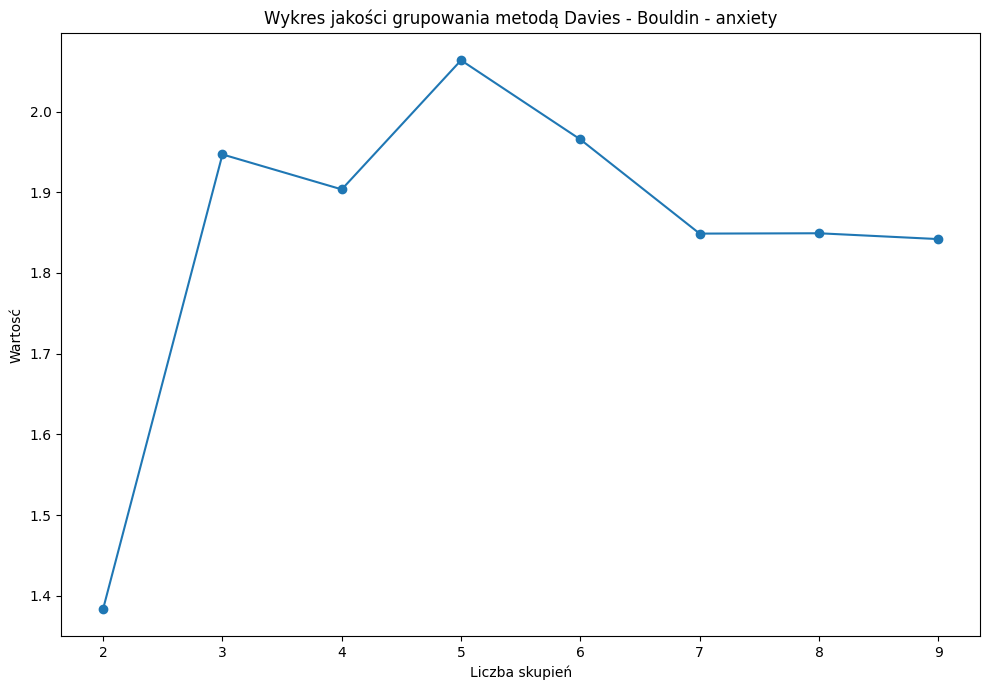

In [11]:
results_anxiety = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    
    kmeans.fit(featuresA) #Grupowanie anxiety
    clustersA = kmeans.predict(featuresA)
    #Obliczenie jakości grupowania
    dbiA = davies_bouldin_score(featuresA, clustersA)
    results_anxiety.append(dbiA)

    
    print("*** Eksperyment numer: " + str(k) + " Jakość dla anxiety = ", dbiA)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_anxiety , marker='o')
plt.title("Wykres jakości grupowania metodą Davies - Bouldin - anxiety")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Miara Calinski-Harabasz

Interpretacja wartości:

Wysokie wartości miary Calinski-Harabasz oznaczają:
- Lepsze separowanie klastrów.
- Większą spójność wewnątrz klastrów.
  
Niskie wartości sugerują słabe grupowanie – klastry są rozproszone lub nakładają się.

In [16]:
from sklearn.metrics import calinski_harabasz_score
clustersA = kmeansA.fit_predict(featuresA)
ch_score = calinski_harabasz_score(featuresA, clustersA)
print("Calinski-Harabasz score, liczba skupień 2:", ch_score)

ch_score3 = calinski_harabasz_score(featuresA, clustersA3)
print("Calinski-Harabasz score, liczba skupień 3:", ch_score3)

Calinski-Harabasz score, liczba skupień 2: 59.30320119999278
Calinski-Harabasz score, liczba skupień 3: 39.72785768357306


*** Eksperyment numer: 2 Jakość dla anxiety =  59.30320119999278
*** Eksperyment numer: 3 Jakość dla anxiety =  39.72785768357306
*** Eksperyment numer: 4 Jakość dla anxiety =  31.1238366891952
*** Eksperyment numer: 5 Jakość dla anxiety =  26.290279997021184
*** Eksperyment numer: 6 Jakość dla anxiety =  24.059050361792508
*** Eksperyment numer: 7 Jakość dla anxiety =  22.209750289419954
*** Eksperyment numer: 8 Jakość dla anxiety =  20.038115111362053
*** Eksperyment numer: 9 Jakość dla anxiety =  18.347763334315314


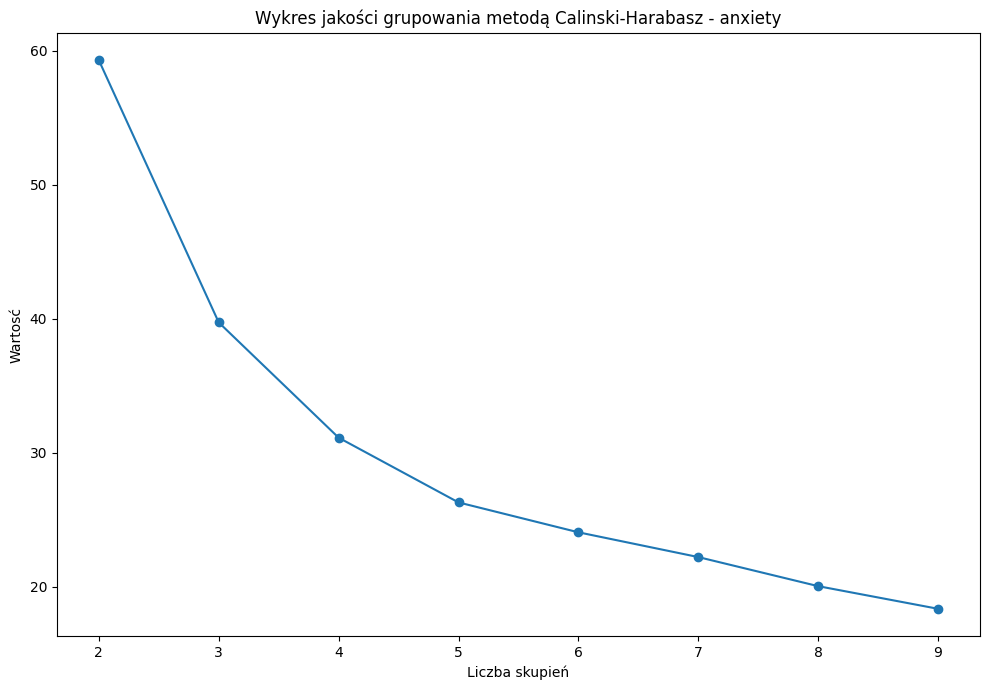

In [13]:
results_anxiety = []
for k in range(2, 10):
        
    #Utworzenie obiektu do grupowania    
    kmeans = KMeans(n_clusters=k,init='k-means++',n_init=10,max_iter=300,random_state=0)
    
    kmeans.fit(featuresA) #Grupowanie anxiety
    clustersA = kmeans.predict(featuresA)
    #Obliczenie jakości grupowania
    ch_scoreA = calinski_harabasz_score(featuresA, clustersA)
    results_anxiety.append(ch_scoreA)

    print("*** Eksperyment numer: " + str(k) + " Jakość dla anxiety = ", ch_scoreA)

fig = plt.figure(figsize=(10, 7))
plt.plot(range(2,n), results_anxiety , marker='o')
plt.title("Wykres jakości grupowania metodą Calinski-Harabasz - anxiety")
plt.xlabel('Liczba skupień')
plt.ylabel('Wartosć')
plt.tight_layout()
plt.show()

# Wizualizacja skupień 
Metoda PCA

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


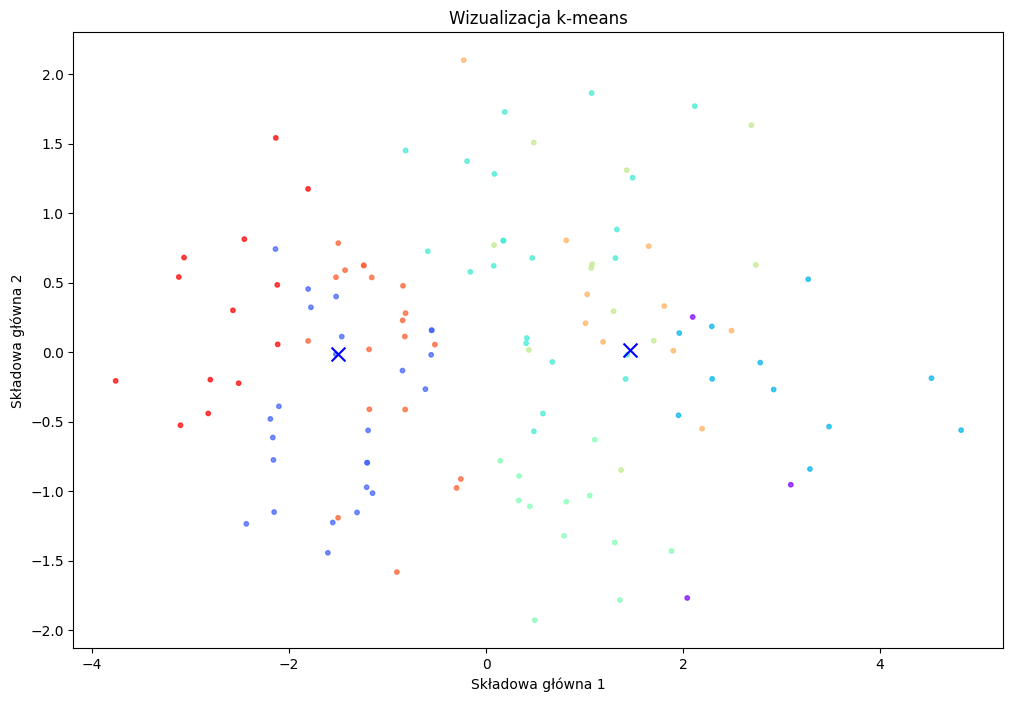

In [125]:
#Anxiety
clustersA = kmeans.fit_predict(featuresA)

#Redukcja wymiarów za pomocą PCA - dane są sprowadzane do 2 wymiarów
pca = PCA(n_components=2)
features_pca = pca.fit_transform(featuresA)
centroids_pca = pca.transform(centroidsA)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja k-means')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersA, cmap='rainbow', s=10, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, color='blue', marker='x')
plt.xlabel('Składowa główna 1')
plt.ylabel('Składowa główna 2')
plt.show()

# Grupowanie metodą hierarchiczną

In [126]:
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
ac.fit(featuresA)

print(len(featuresA))

clustersHierarchy = ac.fit_predict(featuresA)

#for i in range(0,len(clustersA)):
    #print("Obiekt numer:"+str(i)," Skupienie:"+str(clustersHierarchy[i]))

126


# Wizualizacje grupowania hierarchicznego

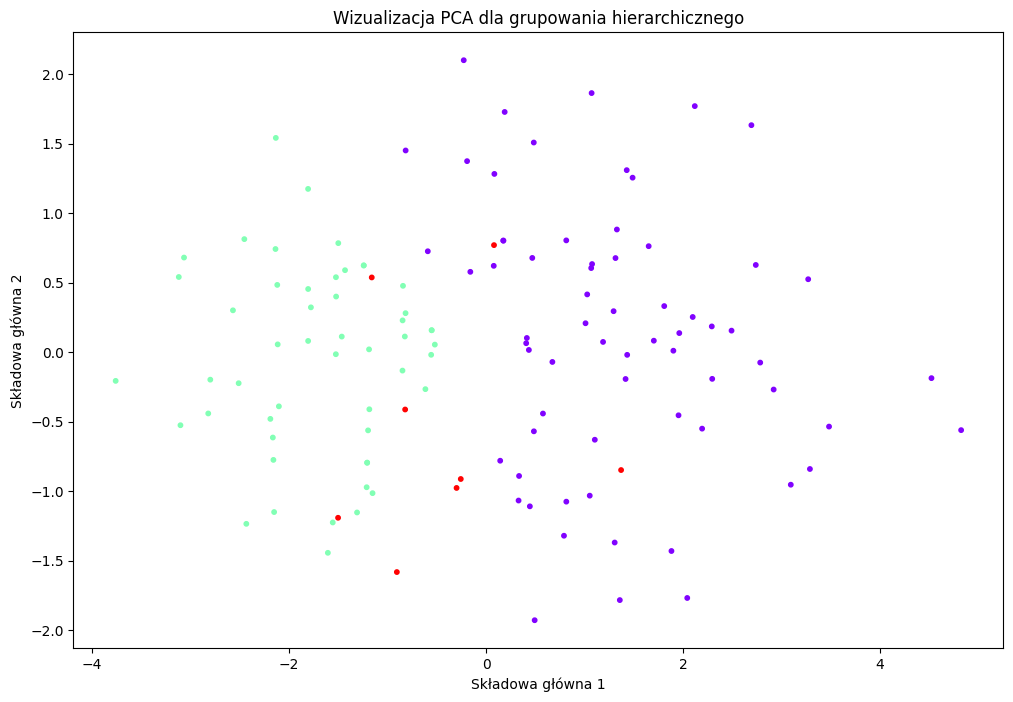

In [127]:
#Anxiety
# Redukcja wymiarów za pomocą PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(featuresA)

plt.figure(figsize=(12, 8))
plt.title('Wizualizacja PCA dla grupowania hierarchicznego')
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clustersHierarchy, s=10, alpha=0.99, cmap='rainbow')
plt.xlabel("Składowa główna 1")
plt.ylabel("Składowa główna 2")
plt.show()

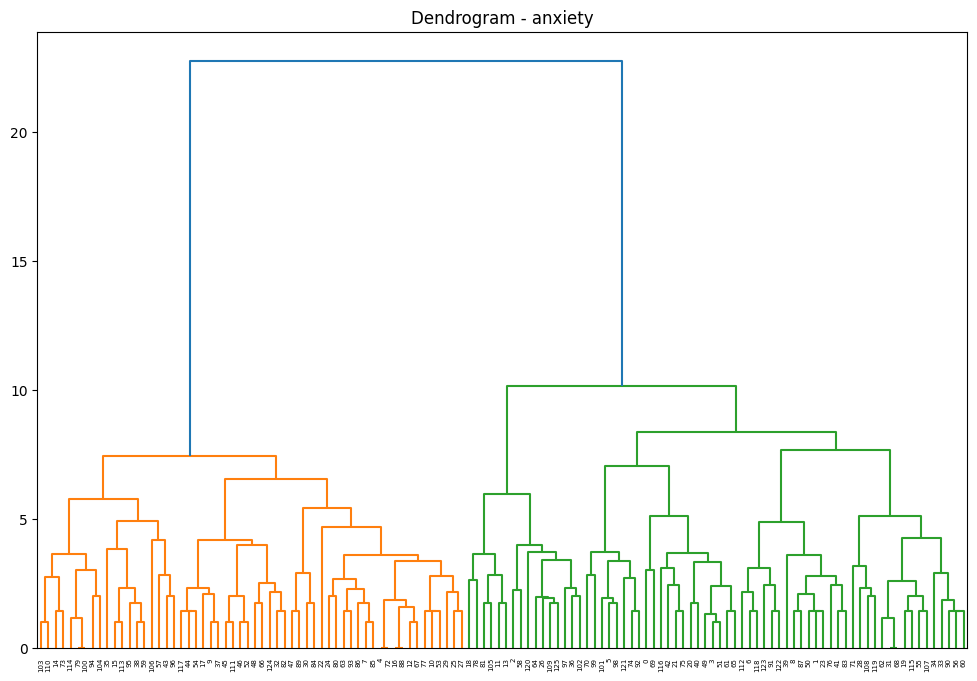

In [128]:
#Dendrogram - anxiety

plt.figure(figsize=(12, 8))
plt.title("Dendrogram - anxiety")
dend = shc.dendrogram(shc.linkage(featuresA, method='ward'))
plt.show()

# Właściwe grupowanie

In [6]:
kmeansA = KMeans(n_clusters=2, #Liczba skupień
                init='k-means++',
                n_init=10,
                max_iter=300, #Maksymalna liczba iteracji algorytmu
                random_state=0, #Ustawienie ziarna generatora liczb pseudo-losowych                
               )

kmeansA.fit(featuresA) #Grupowanie

inertiaA = kmeansA.inertia_
print("Miara jakości=",inertiaA);

centroidsA = kmeansA.cluster_centers_
print("Centroidy: \n",centroidsA)

clustersA = kmeansA.fit_predict(featuresA)

Miara jakości= 520.343776106934
Centroidy: 
 [[2.48148148 2.         2.11111111 2.         1.96296296 1.81481481
  1.18518519 2.03703704 2.         1.81481481]
 [1.21052632 0.54385965 0.92982456 0.89473684 0.43859649 0.61403509
  0.07017544 0.71929825 0.59649123 0.66666667]
 [2.04761905 1.26190476 1.76190476 1.5        1.02380952 1.19047619
  0.4047619  1.88095238 1.11904762 1.45238095]]


# Przypisanie grup do danych

In [7]:
# Przypisanie grup do danych - anxiety
anxietyGroups = anxiety.copy()
new_column = pd.Series(clustersA, name='group')
anxietyGroups = pd.concat([anxietyGroups, new_column], axis=1)

#print(anxietyGroups.head(10))

#Zestawienie wszystkich grup z wszystkimi
wiersze = []

for i in range(0,len(anxietyGroups)-1):
    for j in range(0,len(anxietyGroups)-1):
        if i != j:
            index_i = pd.Series(anxietyGroups.index[i], index=['index_i'])
            features_i = anxietyGroups.iloc[i,0:10].reset_index(drop=True)
            features_i.index = [f'feature_{k}_i' for k in range(0,len(features_i))]
            group_i = pd.Series(anxietyGroups.iloc[i,13], index=['group_i'])
            index_j = pd.Series(anxietyGroups.index[j], index=['index_j'])
            features_j = anxietyGroups.iloc[j,0:10].reset_index(drop=True)
            features_j.index = [f'feature_{k}_j' for k in range(0,len(features_j))]
            group_j = pd.Series(anxietyGroups.iloc[j,13], index=['group_j'])
            wiersz = pd.concat([features_i, features_j, index_i , group_i, index_j, group_j], axis=0)
            wiersze.append(wiersz)

anxietyZestawienie = pd.DataFrame(wiersze)

In [140]:
print(anxietyZestawienie.tail(5))

      feature_0_i feature_1_i feature_2_i feature_3_i feature_4_i feature_5_i  \
15495           1           0           0           2           0           0   
15496           1           0           0           2           0           0   
15497           1           0           0           2           0           0   
15498           1           0           0           2           0           0   
15499           1           0           0           2           0           0   

      feature_6_i feature_7_i feature_8_i feature_9_i  ... feature_4_j  \
15495           0           0           0           1  ...           1   
15496           0           0           0           1  ...           3   
15497           0           0           0           1  ...           1   
15498           0           0           0           1  ...           1   
15499           0           0           0           1  ...           0   

      feature_5_j feature_6_j feature_7_j feature_8_j feature_9_j in

In [8]:
#DataFrame - tylko cechy
anxietyGroups2 = anxietyGroups.copy()
columns_to_drop = ["date","email","gender"]
anxietyGroups2 = anxietyGroups2.drop(columns=columns_to_drop)
print(anxietyGroups2)

    f_0 f_1 f_2 f_3 f_4 f_5 f_6 f_7 f_8 f_9  group
0     3   3   2   3   3   2   0   2   3   0      0
1     2   2   2   1   2   2   0   1   1   1      2
2     3   3   1   2   2   2   2   1   1   1      0
3     2   2   2   2   2   2   1   2   2   2      0
4     1   1   1   1   1   1   0   1   1   2      1
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..    ...
121   2   2   3   1   1   2   0   2   0   2      2
122   1   2   2   2   1   1   1   1   1   1      2
123   2   2   2   2   0   1   0   0   0   2      2
124   1   0   0   2   0   0   0   0   0   1      1
125   2   2   3   2   1   2   1   2   1   2      0

[126 rows x 11 columns]


In [9]:
# Funkcja do zliczania wartości w każdej grupie
group_counts = anxietyGroups2.groupby('group').agg(lambda col: col.value_counts().to_dict())
print(group_counts)
# Rozwinięcie wyników do macierzy liczności
expanded_counts = anxietyGroups2.melt(id_vars='group', var_name='feature', value_name='value')
value_counts = expanded_counts.groupby(['group', 'feature', 'value']).size().unstack(fill_value=0)
print("\n\n", value_counts)

                                      f_0                                 f_1  \
group                                                                           
0              {'3': 14, '2': 12, '1': 1}           {'2': 17, '3': 5, '1': 5}   
1      {'1': 36, '2': 15, '0': 5, '3': 1}                  {'1': 31, '0': 26}   
2      {'2': 25, '3': 10, '1': 6, '0': 1}  {'1': 20, '2': 15, '0': 6, '3': 1}   

                                      f_2                                 f_3  \
group                                                                           
0               {'2': 14, '3': 8, '1': 5}           {'2': 19, '3': 4, '1': 4}   
1      {'1': 34, '0': 14, '2': 8, '3': 1}          {'1': 35, '0': 14, '2': 8}   
2      {'2': 22, '1': 12, '3': 6, '0': 2}  {'1': 23, '2': 14, '3': 4, '0': 1}   

                                      f_4                                f_5  \
group                                                                          
0               {'2': 14, '1

# Drzewo decyzyjne

In [133]:
#Anxiety
anxietyData = pd.concat([anxiety.iloc[:,0:9], new_column], axis=1)
print(len(anxietyData))

noColumn = anxietyData.shape[1]
featuresA = anxietyData.iloc[:,:noColumn-1]
labelsA = anxietyData.iloc[:,[noColumn-1]]

datasetsA = train_test_split(featuresA, labelsA, test_size=0.3, random_state=1234)

#Dla test_size = 0.4 i 0.2 dokładność jest niższa - optymalna dla 0.3

features_train = datasetsA[0]
features_test = datasetsA[1]
labels_train = datasetsA[2]
labels_test = datasetsA[3]

#Parametry drzewa
model =  DecisionTreeClassifier(criterion='gini', 
                               max_depth=5,
                               min_samples_split=10,                                
                               min_samples_leaf=10,
                               max_leaf_nodes=30,
                               min_impurity_decrease=0.02)

model.fit(features_train, np.ravel(labels_train))
labels_predicted = model.predict(features_test)
accuracy = metrics.accuracy_score(labels_test, labels_predicted)
print(f"Dokładność: {accuracy}")
print("========= PEŁNE WYNIKI KLASYFIKACJI ================")
report = classification_report(labels_test, labels_predicted)
print(report )
print("====== MACIERZ POMYŁEK (confusion matrix) +=========")
conf_matrix = confusion_matrix(labels_test, labels_predicted)
print(conf_matrix)

126
Dokładność: 0.5526315789473685
========= PEŁNE WYNIKI KLASYFIKACJI ================
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.64      0.78      0.70        18
           2       0.43      0.43      0.43        14

    accuracy                           0.55        38
   macro avg       0.52      0.46      0.46        38
weighted avg       0.54      0.55      0.53        38

====== MACIERZ POMYŁEK (confusion matrix) +=========
[[ 1  1  4]
 [ 0 14  4]
 [ 1  7  6]]


Wizualizacja tekstowa:
|--- f_0 <= 1.50
|   |--- class: 1
|--- f_0 >  1.50
|   |--- f_5 <= 1.50
|   |   |--- f_2 <= 1.50
|   |   |   |--- class: 1
|   |   |--- f_2 >  1.50
|   |   |   |--- class: 2
|   |--- f_5 >  1.50
|   |   |--- f_6 <= 0.50
|   |   |   |--- class: 2
|   |   |--- f_6 >  0.50
|   |   |   |--- class: 0



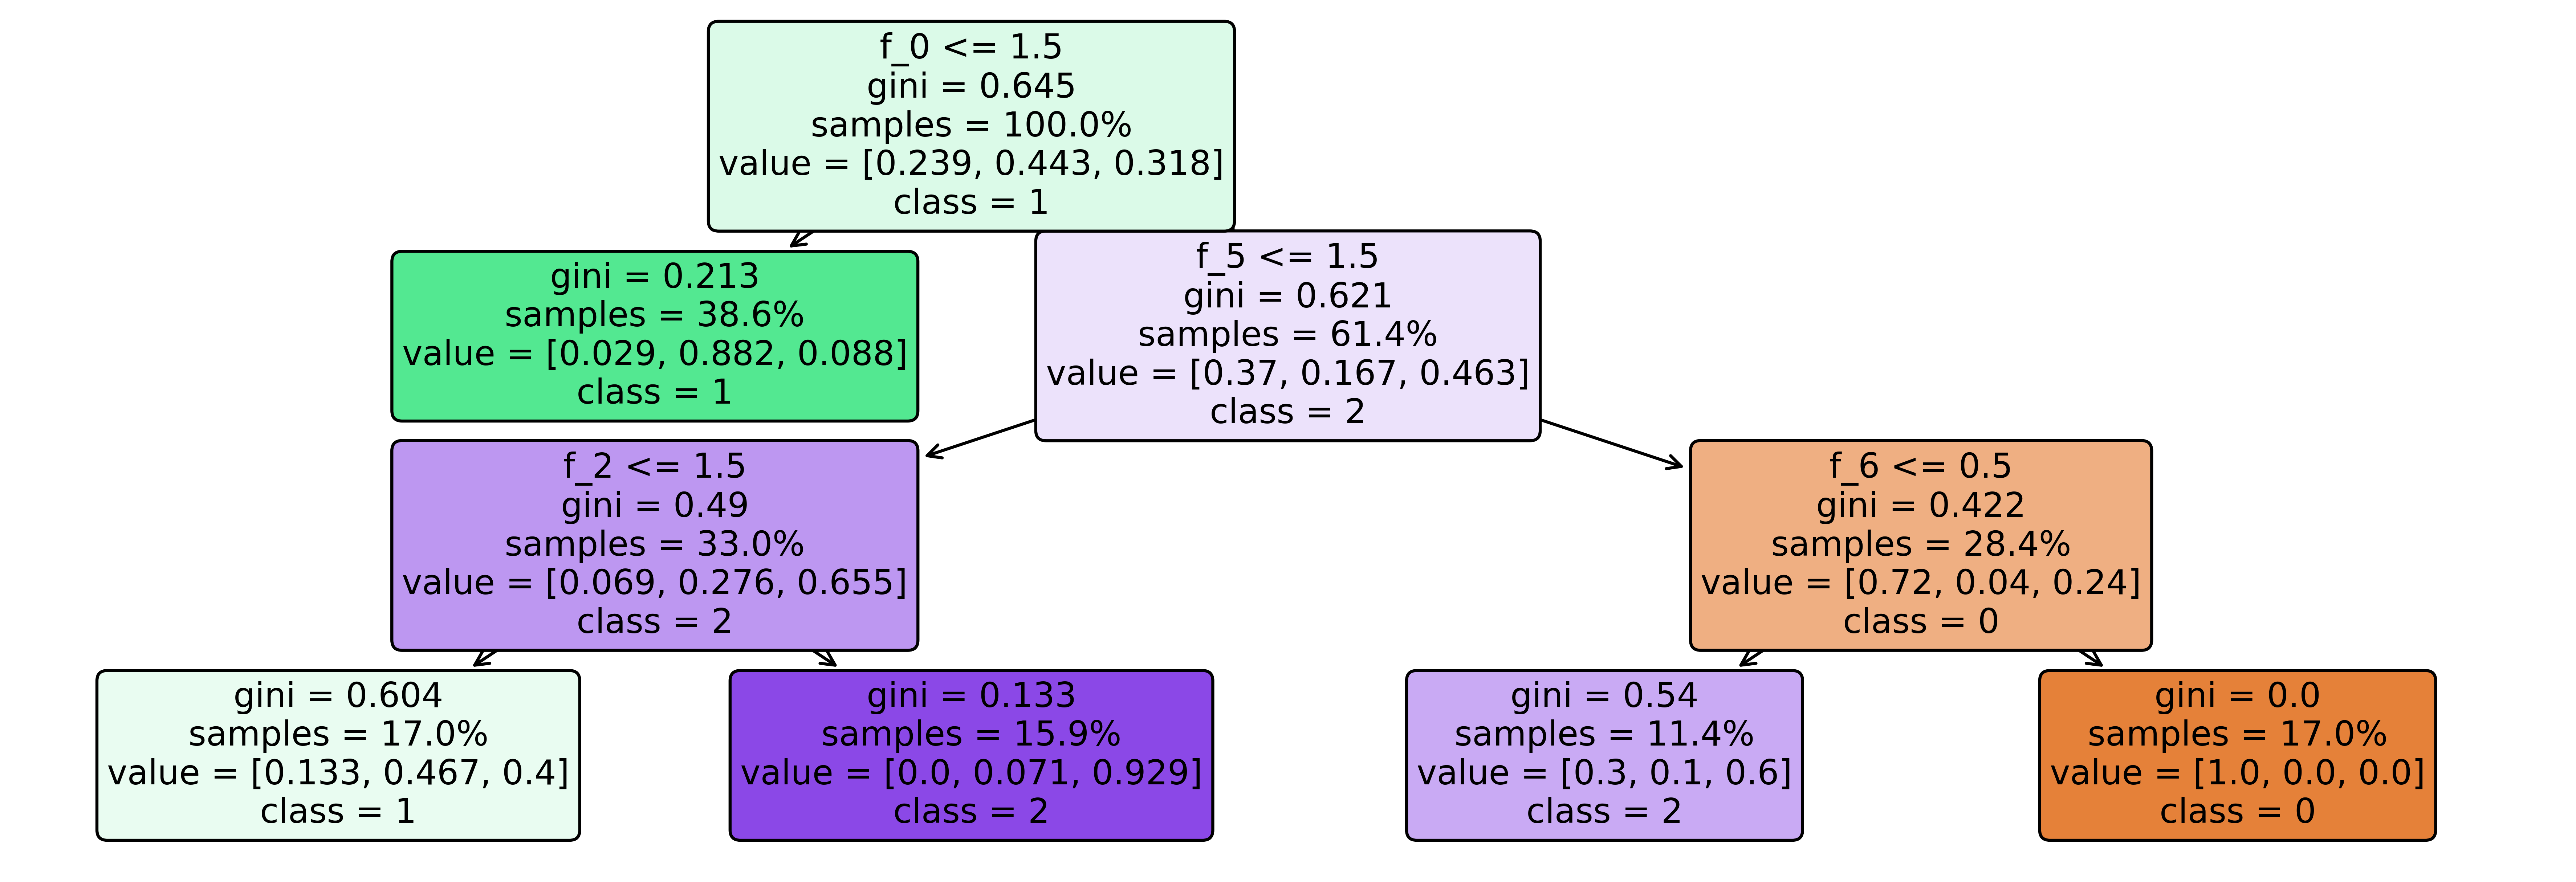

In [134]:
features_names = list(featuresA)
from sklearn import tree
from sklearn.tree import plot_tree

#Pozyskiwanie wartości decyzji
class_names_ordered = sorted(np.unique(labelsA))
my_class_names = []
for i in range(0,len(class_names_ordered)):
    my_class_names.append(str(class_names_ordered[i]))

text_representation = tree.export_text(model,feature_names=features_names,class_names=my_class_names,)
print("Wizualizacja tekstowa:")
print(text_representation)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5), dpi = 600)
plot_tree(model, feature_names=features_names, class_names=my_class_names, rounded=True, filled=True, proportion=True);

# Reguły decyzyjne

In [17]:
# Reguły decyzyjne
anxietyRules = anxietyZestawienie.copy()
#print(anxietyRules.head(1))

#Zestawienie wszystkich grup z wszystkimi
rows = []

for i in range(0,len(anxietyRules)):
    row = anxietyRules.iloc[i]
    if int(row['group_i']) != int(row['group_j']): #wykluczenie wierszy, w których nie ma zmiany grupy
        wiersz = {
            'feature_0': f"\"{row['feature_0_i']}-{row['feature_0_j']}\"",
            'feature_1': f"\"{row['feature_1_i']}-{row['feature_1_j']}\"",
            'feature_2': f"\"{row['feature_2_i']}-{row['feature_2_j']}\"",
            'feature_3': f"\"{row['feature_3_i']}-{row['feature_3_j']}\"",
            'feature_4': f"\"{row['feature_4_i']}-{row['feature_4_j']}\"",
            'feature_5': f"\"{row['feature_5_i']}-{row['feature_5_j']}\"",
            'feature_6': f"\"{row['feature_6_i']}-{row['feature_6_j']}\"",
            'feature_7': f"\"{row['feature_7_i']}-{row['feature_7_j']}\"",
            'feature_8': f"\"{row['feature_8_i']}-{row['feature_8_j']}\"",
            'feature_9': f"\"{row['feature_9_i']}-{row['feature_9_j']}\"",
            'group': f"\"{row['group_i']}-{row['group_j']}\""
        }
        rows.append(wiersz)

anxietyRules = pd.DataFrame(rows)
print(anxietyRules)

     feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6 feature_7 feature_8 feature_9 group 
0       "3-2"     "3-2"     "2-2"     "3-1"     "3-2"     "2-2"     "0-0"     "2-1"     "3-1"     "0-1"   "0-2"
1       "3-1"     "3-1"     "2-1"     "3-1"     "3-1"     "2-1"     "0-0"     "2-1"     "3-1"     "0-2"   "0-1"
2       "3-3"     "3-0"     "2-2"     "3-2"     "3-2"     "2-1"     "0-0"     "2-3"     "3-1"     "0-2"   "0-2"
3       "3-2"     "3-2"     "2-1"     "3-1"     "3-1"     "2-1"     "0-1"     "2-2"     "3-1"     "0-1"   "0-2"
4       "3-1"     "3-0"     "2-1"     "3-0"     "3-0"     "2-1"     "0-0"     "2-1"     "3-1"     "0-1"   "0-1"
...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...
9931    "1-2"     "0-1"     "0-1"     "2-1"     "0-1"     "0-0"     "0-0"     "0-3"     "0-1"     "1-2"   "1-2"
9932    "1-2"     "0-1"     "0-1"     "2-2"     "0-3"     "0-1"     "0-3"     "0-3"     "0-0"     "1-2" 

In [18]:
anxietyRules.to_csv('anxietyZestawienie.csv', index=False)

# Eksport do formatu RSES

In [136]:
# Funkcja do eksportu DataFrame do formatu RSES
def export_to_tab(df, attributes_info, table_name, filename):
    """
    Eksportuje DataFrame do pliku w formacie tabelarycznym (tab).
    
    :param df: Pandas DataFrame z danymi.
    :param attributes_info: Lista krotek (nazwa_atrybutu, typ, [precision]).
    :param table_name: Nazwa tabeli.
    :param filename: Nazwa pliku wyjściowego.
    """
    with open(filename, 'w') as f:
        # Nagłówek
        f.write(f'TABLE "{table_name}"\n')
        f.write(f'ATTRIBUTES {len(attributes_info)}\n')
        for attr in attributes_info:
            line = f' {attr[0]} {attr[1]}'
            if len(attr) > 2:  # Jeśli podano precyzję
                line += f' {attr[2]}'
            f.write(line + '\n')
        f.write(f'OBJECTS {len(df)}\n')
        
        # Dane obiektów
        for _, row in df.iterrows():
            f.write(" ".join(map(str, row.values)) + '\n')

    print(f"Eksport zakończony. Plik został zapisany jako {filename}.")

In [142]:
attributes_info = [
    ("f_0","symbolic"),
    ("f_1","symbolic"),
    ("f_2","symbolic"),
    ("f_3","symbolic"),
    ("f_4","symbolic"),
    ("f_5","symbolic"),
    ("f_6","symbolic"),
    ("f_7","symbolic"),
    ("f_8","symbolic"),
    ("f_9","symbolic"),
    ("group","symbolic"),
]

# Eksport danych do pliku tab
export_to_tab(anxietyRules, attributes_info, table_name="anxiety", filename="anxiety_2_rules.tab")

Eksport zakończony. Plik został zapisany jako anxiety_2_rules.tab.
